### Data Load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from utils.funcs import *

### Proteins Comparision

In [5]:
wls_cbm, cd_abs_cbm, error_cbm = cdproc(3,'CD_data/08-05-24',water=True)
wls_b1, cd_abs_b1, error_b1 = cdproc(4,'CD_data/08-05-24',water=True)

In [8]:
wls_cbm_1, cd_abs_cbm_1, error_cbm_1 = cdproc(4,'CD_data/CBM_before_ramp',water=False)
wls_b1_1, cd_abs_b1_1, error_b1_1 = cdproc(1,'CD_data/B1_before_ramp',water=False)

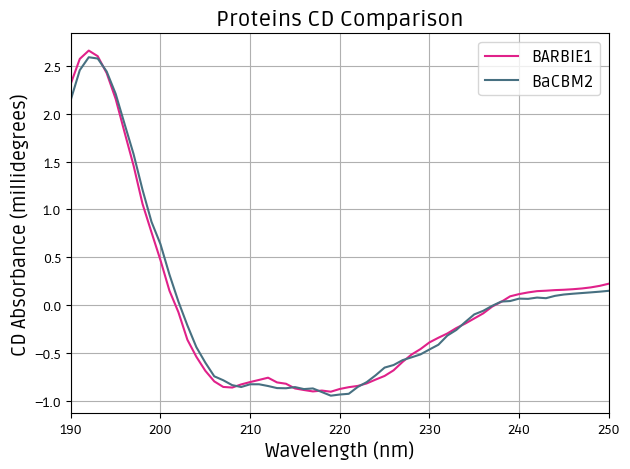

In [7]:
cdplot(wls_b1,cd_abs_b1,'BARBIE1','#E0218A')
cdplot(wls_cbm,cd_abs_cbm,'BaCBM2','#477081')

# Sem normalização
plt.xlim(190,250)
# plt.xlim(200,250), plt.ylim(-2,2)
plt.title('Proteins CD Comparison',fontsize=16)
plt.grid(), plt.tight_layout()

plt.savefig('results/wiki/cbmxb1_cd.png',dpi=500,transparent=True)

plt.show()

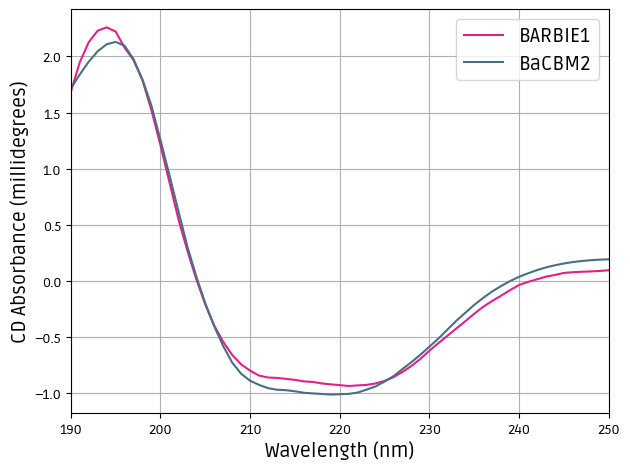

In [11]:
cdplot(wls_b1_1,cd_abs_b1_1,'BARBIE1','#E0218A')
cdplot(wls_cbm_1,cd_abs_cbm_1,'BaCBM2','#477081')

# Sem normalização
plt.xlim(190,250)
# plt.xlim(200,250), plt.ylim(-2,2)
plt.grid(), plt.tight_layout()
plt.legend(fontsize=14)

plt.savefig('results/wiki/cbmxb1_cd.png',dpi=500,transparent=True)

plt.show()

### Heating Ramp

In [12]:
wls_b1, temp_b1, cd_abs_b1, error_b1 = rampproc('CD_data/B1-CBM-ramp',25,1,96)
wls_cbm, temp_cbm, cd_abs_cbm, error_cbm = rampproc('CD_data/BaCBM2-ramp',25,1,96)

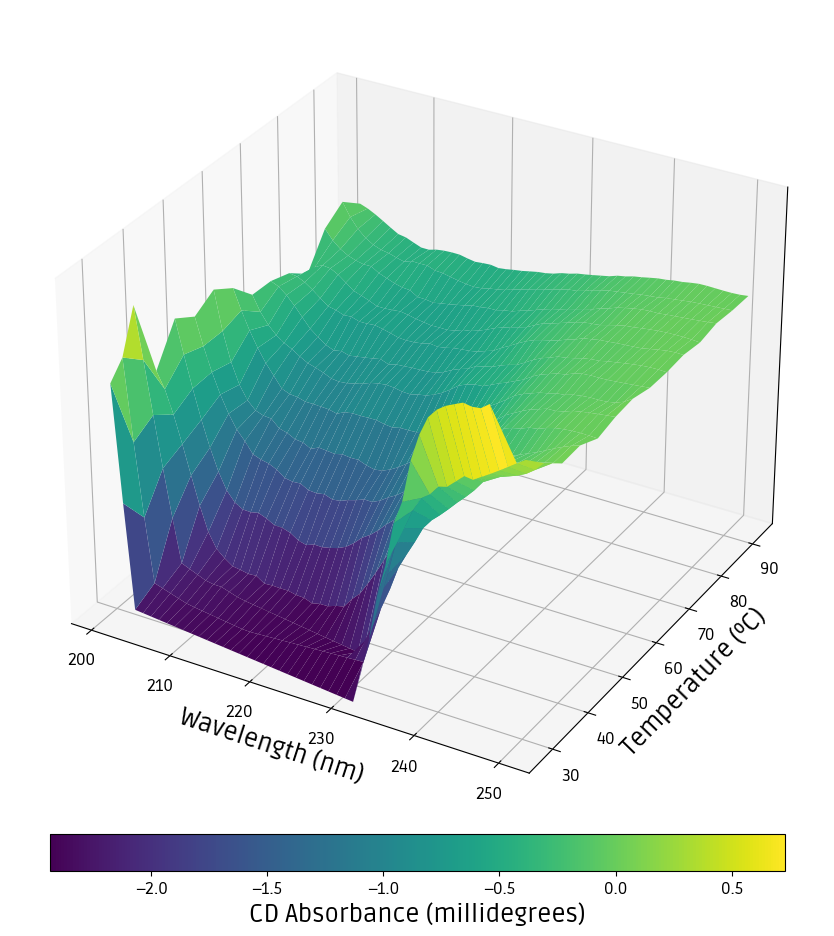

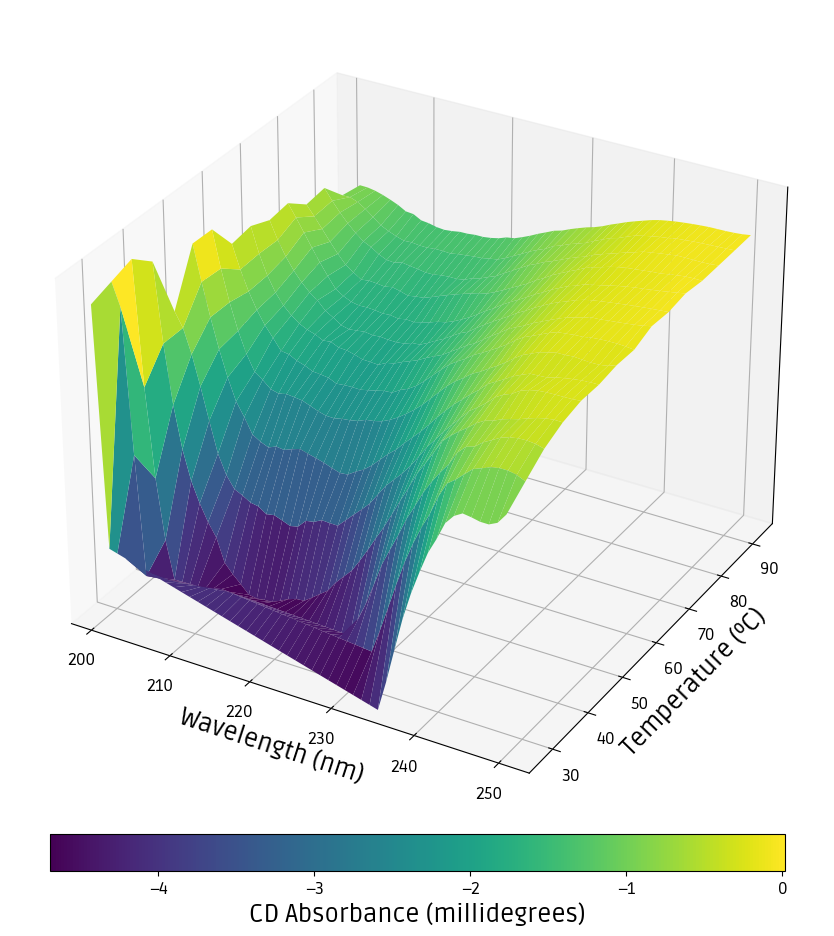

In [13]:
ax = rampplot(wls_b1, temp_b1, cd_abs_b1)
ax.view_init(30,-60)
ax.xaxis.set_tick_params(labelsize=12),ax.yaxis.set_tick_params(labelsize=12),ax.set_zticks([])
plt.savefig('results/CD_results/b1_ramp.png',dpi=700,transparent=True)
plt.show()

ax = rampplot(wls_cbm, temp_cbm, cd_abs_cbm)
ax.view_init(30,-60)
ax.xaxis.set_tick_params(labelsize=12),ax.yaxis.set_tick_params(labelsize=12),ax.set_zticks([])
plt.savefig('results/CD_results/cbm_ramp.png',dpi=700,transparent=True)
plt.show()

In [12]:
wls_b1_heat, temp_b1_heat, cd_abs_b1_heat, error_b1_heat = rampproc('CD_data/B1_heating_cooling',25,1,96)
wls_b1_cool, temp_b1_cool, cd_abs_b1_cool, error_b1_cool = rampproc('CD_data/B1_heating_cooling',90,96,186,cold=True)
# wls_cbm, temp_cbm, cd_abs_cbm, error_cbm = rampproc('CD_data/CBM_heating_cooling',25,1,96)

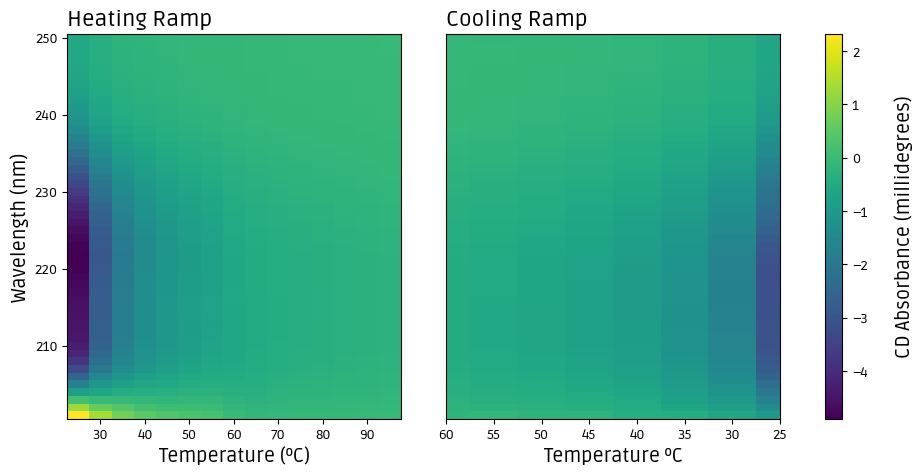

In [13]:
ramp2d(cd_abs_b1_heat,cd_abs_b1_cool,wls_b1_heat,wls_b1_cool,temp_b1_heat,temp_b1_cool)
# plt.savefig('results/CD_results/nt2repct_heating_ramp.png',dpi=700,transparent=True)

### Pontual Spectra

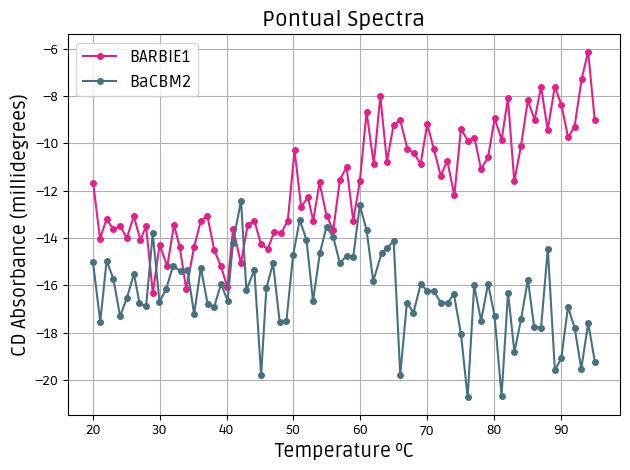

In [14]:
pontualspectra('CD_data/pontual_spectra/Barbie1/pontual B1.asc','BARBIE1','#E0218A')
pontualspectra('CD_data/pontual_spectra/CBM/pontual CBM.asc','BaCBM2','#477081')

plt.xlabel('Temperature ºC',fontsize=14),plt.ylabel('CD Absorbance (millidegrees)',fontsize=14)

plt.legend(fontsize=12)
plt.title('Pontual Spectra',fontsize=16)
plt.grid(),plt.tight_layout()

plt.savefig('results/CD_results/pontual_spectra.png',dpi=700,transparent=True)

plt.show()

### Plastic Interaction

In [15]:
wls_npl,cd_abs_npl,error_npl = cdproc(3,'CD_Data/08-07-24')
wls_cbm,cd_abs_cbm,error_cbm = cdproc(4,'CD_Data/08-07-24')
wls_b1,cd_abs_b1,error_b1 = cdproc(6,'CD_Data/08-07-24')

In [16]:
wls_cbmnp,cd_abs_cbmnp,error_cbmnp = cdproc(5,'CD_Data/08-07-24')
wls_b1np,cd_abs_b1np,error_b1np = cdproc(7,'CD_Data/08-07-24')

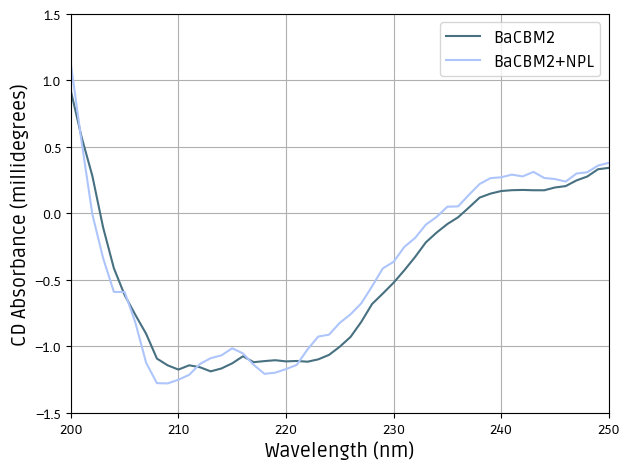

In [17]:
cdplot(wls_b1,cd_abs_cbm,'BaCBM2','#477081')
cdplot(wls_cbm,cd_abs_cbmnp,'BaCBM2+NPL','#AEC5FB')

plt.grid(),plt.xlim(200,250),plt.ylim(-1.5,1.5),plt.tight_layout()
plt.savefig('results/barbie1_npl.png',dpi=500,transparent=True)
plt.show()

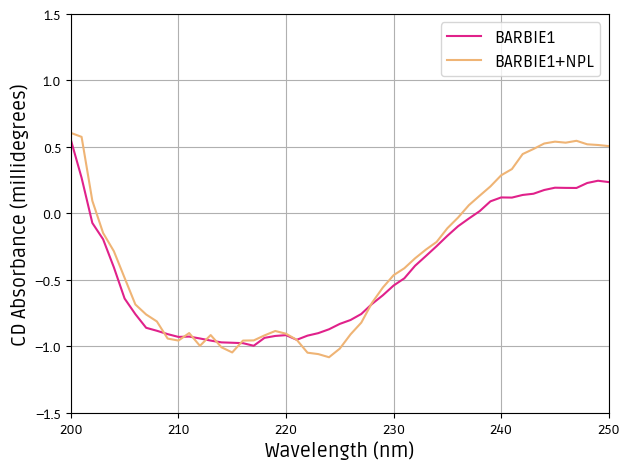

In [18]:
cdplot(wls_b1,cd_abs_b1,'BARBIE1','#E0218A')
cdplot(wls_cbm,cd_abs_b1np,'BARBIE1+NPL','#EFB475')

plt.grid(),plt.xlim(200,250),plt.ylim(-1.5,1.5),plt.tight_layout()
plt.savefig('results/bacbm2_npl.png',dpi=500,transparent=True)
plt.show()

### Unfolding-Refolding

In [3]:
wls_b1_heat, temp_b1_heat, cd_abs_b1_heat, error_b1_heat = rampproc('CD_data/B1_heating_cooling',25,1,96)
wls_b1_cool, temp_b1_cool, cd_abs_b1_cool, error_b1_cool = rampproc('CD_data/B1_heating_cooling',25,96,186)

temp_b1_cool = temp_b1_cool[::-1]

c:\Users\pedro220068\Documents\iGEM\barbie-rep\3_experimental-analysis\utils\funcs.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas,wl_cd,yerr=error,capsize=3,fmt="r--o",color="#E0218A",ecolor = "black")


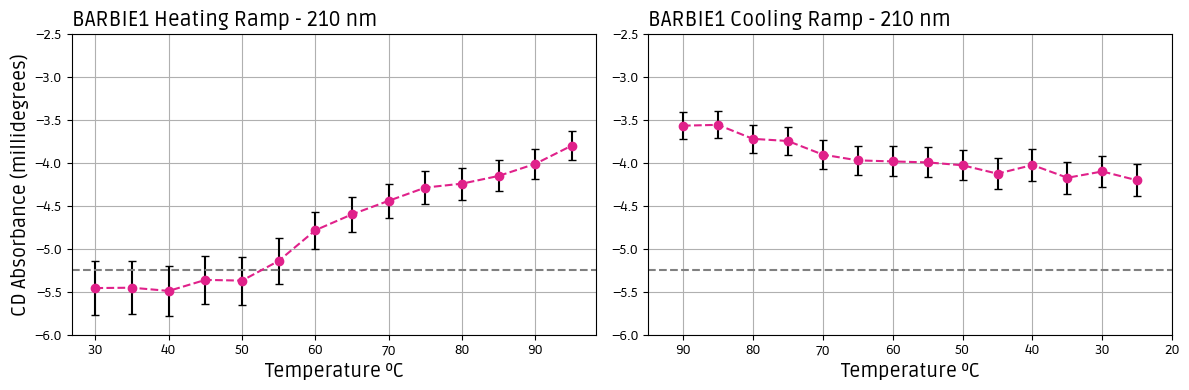

In [5]:
plt.figure(figsize=(12,4))

plt.subplot(121)
wlspectra(210,wls_b1_heat[1:],temp_b1_heat[1:],cd_abs_b1_heat[1:],error_b1_heat[1:])

plt.title('BARBIE1 Heating Ramp - 210 nm',fontsize=15,loc='left')
plt.ylim(-6,-2.5)
plt.axhline(y=-5.25,color='gray',linestyle='--')
plt.ylabel('CD Absorbance (millidegrees)',fontsize=14)
plt.xlabel('Temperature ºC',fontsize=14)
plt.grid()

plt.subplot(122)
wlspectra(210,wls_b1_cool,temp_b1_cool,cd_abs_b1_cool,error_b1_cool)

plt.title('BARBIE1 Cooling Ramp - 210 nm',fontsize=15,loc='left')
plt.xlabel('Temperature ºC',fontsize=14)
plt.ylabel('')
plt.axhline(y=-5.25,color='gray',linestyle='--')

plt.xlim(95,20)
plt.ylim(-6,-2.5)

plt.grid(),plt.tight_layout()
plt.savefig('results/210nm_ramp.png',dpi=700,transparent=True)

plt.show()

c:\Users\pedro220068\Documents\iGEM\barbie-rep\3_experimental-analysis\utils\funcs.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas,wl_cd,yerr=error,capsize=3,fmt="r--o",color="#E0218A",ecolor = "black")


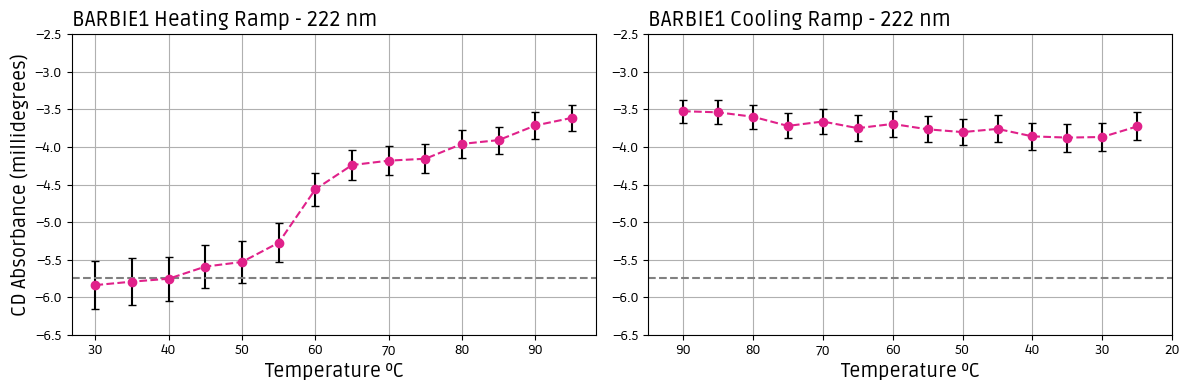

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(121)
wlspectra(222,wls_b1_heat[1:],temp_b1_heat[1:],cd_abs_b1_heat[1:],error_b1_heat[1:])

plt.title('BARBIE1 Heating Ramp - 222 nm',fontsize=15,loc='left')
plt.ylim(-6.5,-2.5)
plt.axhline(y=-5.75,color='gray',linestyle='--')
plt.ylabel('CD Absorbance (millidegrees)',fontsize=14)
plt.xlabel('Temperature ºC',fontsize=14)
plt.grid()

plt.subplot(122)
wlspectra(222,wls_b1_cool,temp_b1_cool,cd_abs_b1_cool,error_b1_cool)

plt.title('BARBIE1 Cooling Ramp - 222 nm',fontsize=15,loc='left')
plt.ylabel('')
plt.xlabel('Temperature ºC',fontsize=14)
plt.axhline(y=-5.75,color='gray',linestyle='--')

plt.xlim(95,20)
plt.ylim(-6.5,-2.5)

plt.grid(),plt.tight_layout()
plt.savefig('results/222nm_ramp.png',dpi=700,transparent=True)

plt.show()

c:\Users\pedro220068\Documents\iGEM\barbie-rep\3_experimental-analysis\utils\funcs.py:121: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas,wl_cd,yerr=error,capsize=3,fmt="r--o",color="#E0218A",ecolor = "black")


[-5.87179199 -3.79143198 58.80714123  6.57607385]


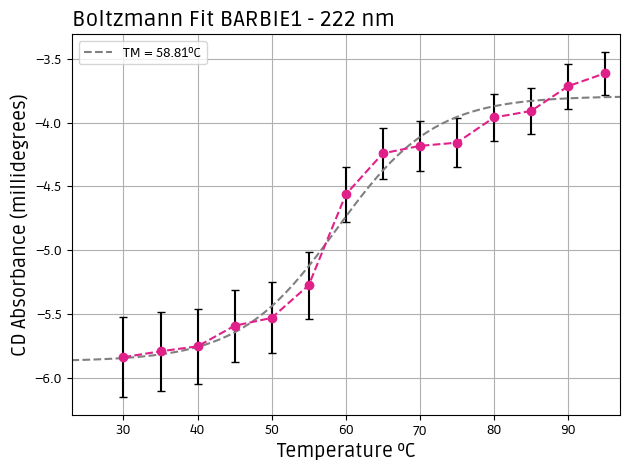

In [4]:
wlspectra(222,wls_b1_heat[1:],temp_b1_heat[1:],cd_abs_b1_heat[1:],error_b1_heat[1:],TM=True)

plt.title('Boltzmann Fit BARBIE1 - 222 nm',fontsize=16,loc='left')
plt.ylabel('CD Absorbance (millidegrees)',fontsize=14),plt.xlabel('Temperature ºC',fontsize=14)
plt.xlim(23,97)

plt.grid(),plt.tight_layout()
plt.savefig('results/boltz.png',transparent=True,dpi=700)
plt.show()

### Before and After

In [4]:
wls_b1_b, cd_abs_b1_b, error_b1_b = cdproc(1,'CD_data/B1_before_ramp',water=True)
wls_b1_a, cd_abs_b1_a, error_b1_a = cdproc(2,'CD_data/B1_after_ramp',water=True)

In [5]:
wls_cbm_b, cd_abs_cbm_b, error_cbm_b = cdproc(4,'CD_data/CBM_before_ramp',water=True)
wls_cbm_a, cd_abs_cbm_a, error_cbm_a = cdproc(1,'CD_data/CBM_after_ramp',water=True)

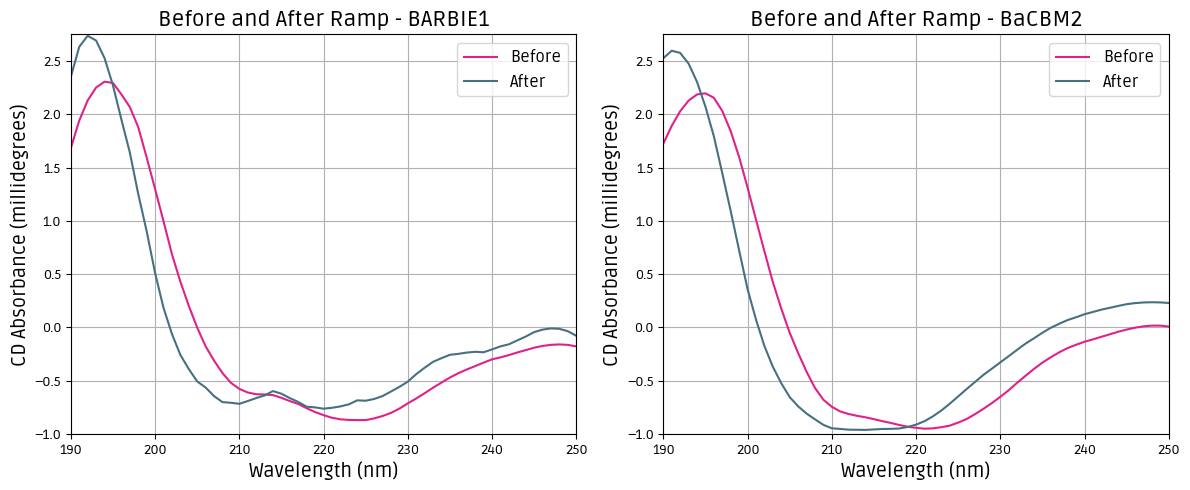

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(121)

cdplot(wls_b1_b,cd_abs_b1_b,'Before','#E0218A')
cdplot(wls_b1_a,cd_abs_b1_a,'After','#477081')

plt.xlim(190,250)
plt.title('Before and After Ramp - BARBIE1',fontsize=16)
plt.grid(), plt.tight_layout(), plt.ylim(-1,2.75)

plt.subplot(122)

cdplot(wls_cbm_b,cd_abs_cbm_b,'Before','#E0218A')
cdplot(wls_cbm_a,cd_abs_cbm_a,'After','#477081')

plt.xlim(190,250)
plt.title('Before and After Ramp - BaCBM2',fontsize=16)
plt.grid(), plt.tight_layout(), plt.ylim(-1,2.75)

plt.savefig('results/CD_results/cbmxb1_cd.png',dpi=500,transparent=True)

plt.show()

### Nt2RepCt

In [50]:
wls_spid, cd_abs_spid, error_spid = cdproc(2,'CD_data/nt2repct/spectrum Nt2repct',water=False)
wls_w, cd_abs_w, error_w = cdproc(1,'CD_data/nt2repct/spectrum h2o',water=False)

In [6]:
cd_abs_spid = np.subtract(cd_abs_spid,cd_abs_w)

In [7]:
wls_spid_heat, temp_spid_heat, cd_abs_spid_heat, error_spid_heat = rampproc('CD_data/nt2repct/rampa Nt2repct',25,1,51,index=4)
wls_spid_cool, temp_spid_cool, cd_abs_spid_cool, error_spid_cool = rampproc('CD_data/nt2repct/rampa Nt2repct',60,51,102,index=4,cold=True)

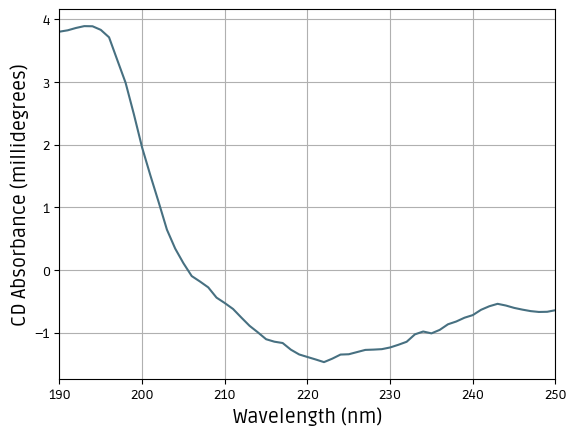

In [31]:
cdplot(wls_spid, cd_abs_spid,l='spid',c='#477081')
plt.xlim(190,250)
plt.grid()
plt.legend('',frameon=False)
plt.show()

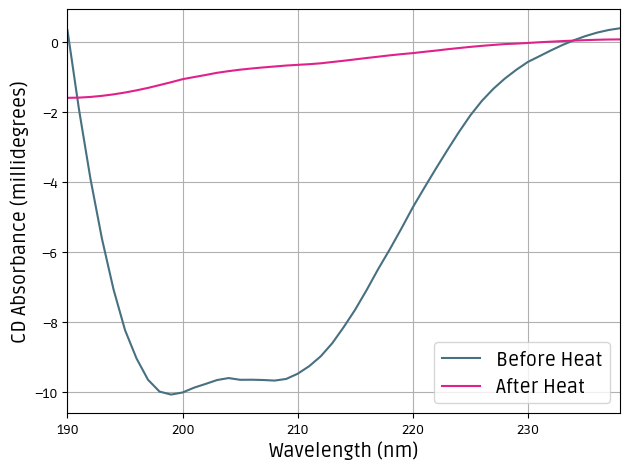

In [39]:
cdplot(wls_spid_heat[11:], cd_abs_spid_heat[0],l='Before Heat',c='#477081')
cdplot(wls_spid_cool[11:], cd_abs_spid_cool[-1],l='After Heat',c='#E0218A')

plt.xlim(190,238)
plt.grid()
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('results/CD_results/nt2repct_beforexafter.png',dpi=700,transparent=True)
plt.show()

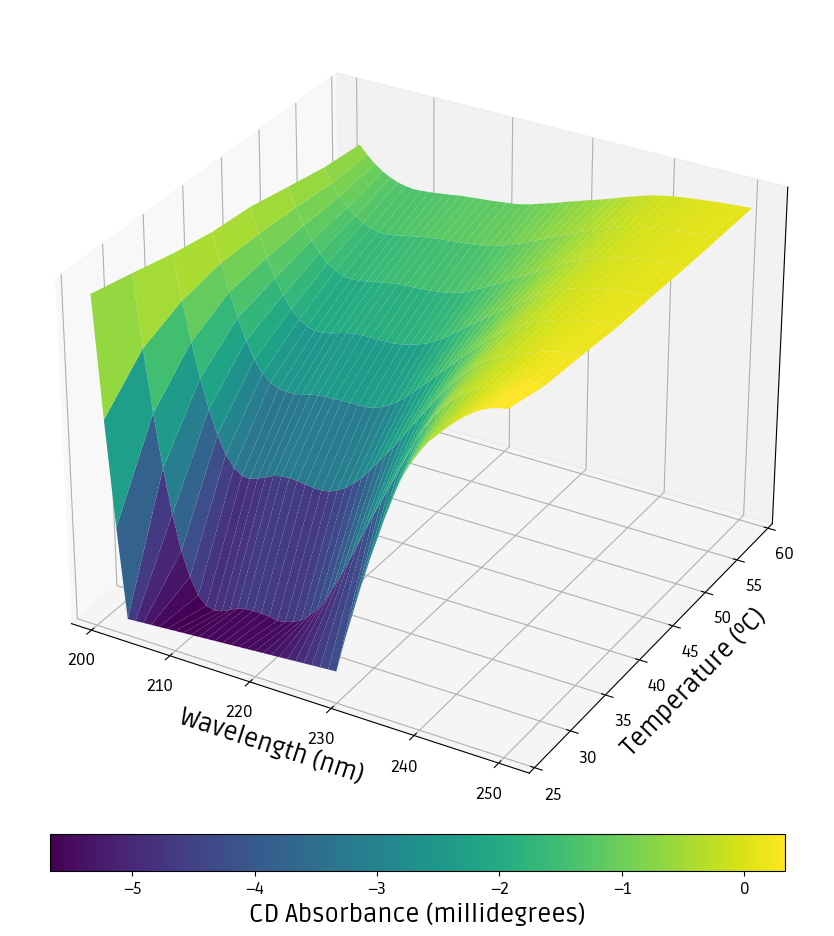

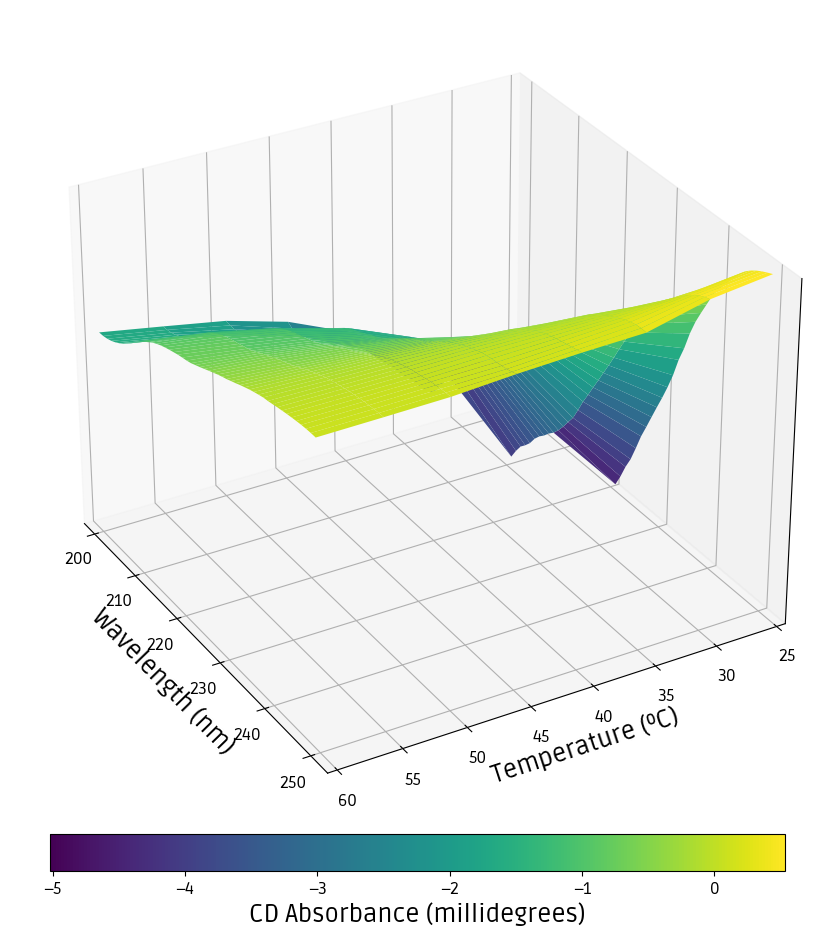

In [14]:
ax = rampplot(wls_spid_heat, temp_spid_heat, cd_abs_spid_heat)
ax.view_init(30,-60)
ax.xaxis.set_tick_params(labelsize=12),ax.yaxis.set_tick_params(labelsize=12),ax.set_zticks([])
# plt.savefig('results/CD_results/b1_ramp.png',dpi=700,transparent=True)
plt.show()

ax = rampplot(wls_spid_cool, temp_spid_cool, cd_abs_spid_cool[::-1])
ax.view_init(30,-30)
ax.set_ylim(60,25)
ax.xaxis.set_tick_params(labelsize=12),ax.yaxis.set_tick_params(labelsize=12),ax.set_zticks([])
# plt.savefig('results/CD_results/b1_ramp.png',dpi=700,transparent=True)
plt.show()

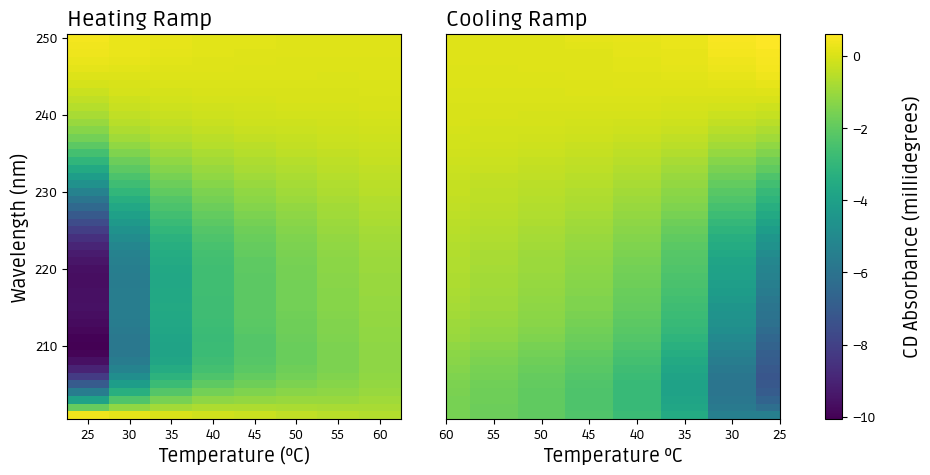

In [41]:
ramp2d(cd_abs_spid_heat,cd_abs_spid_cool,wls_spid_heat,wls_spid_cool,temp_spid_heat,temp_spid_cool)
plt.savefig('results/CD_results/nt2repct_heating_ramp.png',dpi=700,transparent=True)

c:\Users\pedro220068\Documents\iGEM\barbie-rep\3_experimental-analysis\utils\funcs.py:129: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--o" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(temperaturas,wl_cd,yerr=error,capsize=3,fmt="r--o",color=c,ecolor = "black")


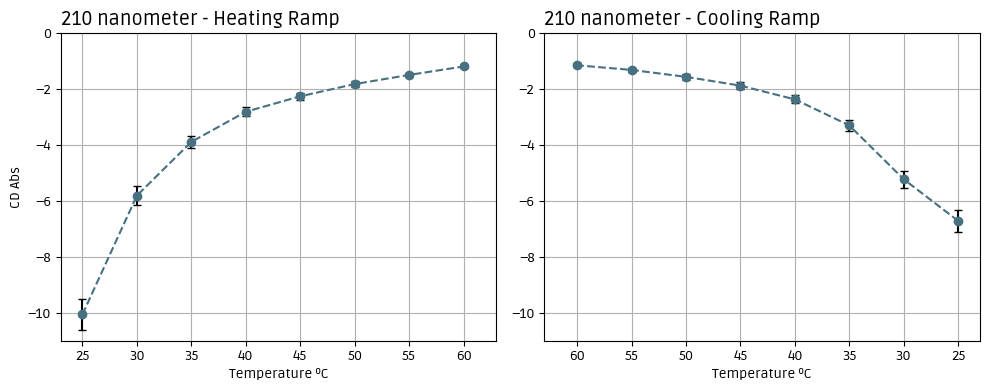

In [47]:
plt.figure(figsize=(10,4))

plt.subplot(121)
wlspectra(210,wls_spid_heat,temp_spid_heat,cd_abs_spid_heat,error_spid_heat,c='#477081')
plt.ylim(-11,0)
plt.xlim(23,63)
# plt.xlabel(fontsize=14),plt.ylabel(fontsize=14)
plt.grid()
plt.title('210 nanometer - Heating Ramp',loc='left',fontsize=14)

plt.subplot(122)
wlspectra(210,wls_spid_cool,temp_spid_cool[::-1],cd_abs_spid_cool,error_spid_cool,c='#477081')
plt.ylabel('')
plt.xlim(63,23)
plt.ylim(-11,0)
# plt.xlabel(fontsize=14),plt.ylabel(fontsize=14)
plt.title('210 nanometer - Cooling Ramp',loc='left',fontsize=14)
plt.grid()

plt.tight_layout()
plt.savefig('results/CD_results/nt2repct_heating_ramp_210.png',dpi=800,transparent=True)
plt.show()

### NtCBM

In [51]:
wls_ntcbm, cd_abs_ntcbm, error_ntcbm = cdproc(1,'CD_data/NtCBM/',water=False,aq=3)

In [69]:
cd_abs_cbm_cut = np.subtract(cd_abs_cbm[30:91],cd_abs_w)
cd_abs_spid_cut = np.subtract(cd_abs_spid,cd_abs_w)
cd_abs_ntcbm_cut = np.subtract(cd_abs_ntcbm[10:61],cd_abs_w[:-10])

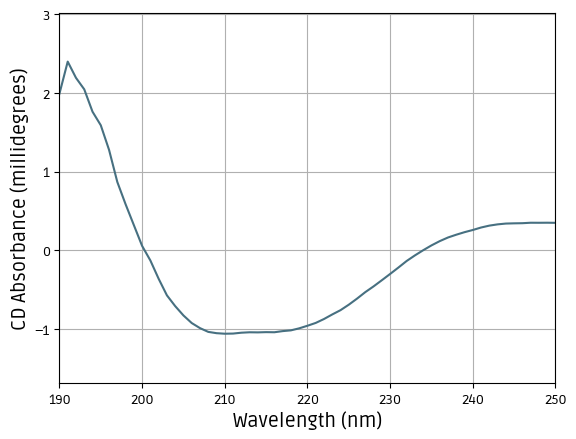

In [5]:
cdplot(wls_ntcbm, cd_abs_ntcbm,l='NtCBM',c='#477081')
plt.xlim(190,250)
plt.grid()
plt.legend('',frameon=False)
plt.show()

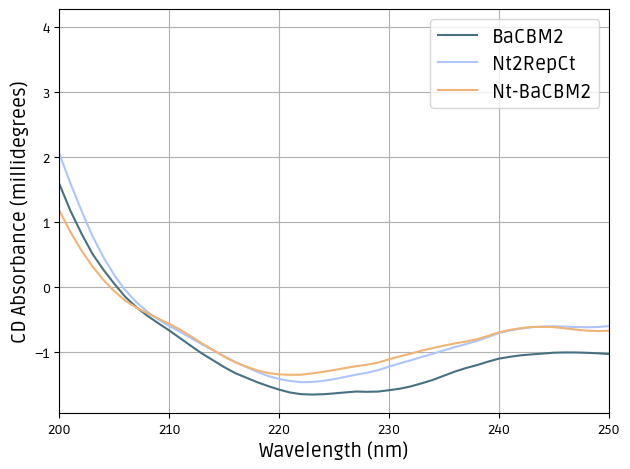

In [72]:
cdplot(wls_cbm[30:91],smooth(cd_abs_cbm_cut),'BaCBM2',c='#477081')
cdplot(wls_spid,smooth(cd_abs_spid_cut),l='Nt2RepCt',c='#AEC5FB')
cdplot(wls_ntcbm[10:61],smooth(cd_abs_ntcbm_cut),l='Nt-BaCBM2',c='#EFB475')

plt.xlim(200,250)
plt.grid()
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('results/CD_results/ntcbm.png',dpi=800,transparent=True)
plt.show()

### Tests

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

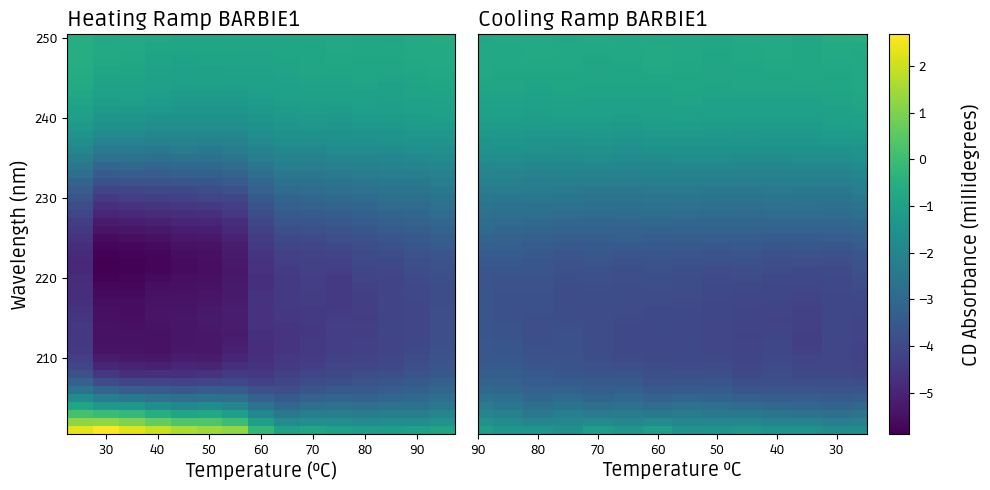

In [43]:
def proc(wls, temp, ramp_plot, min_val, max_val):
    # Garantir que wls e temp tenham o mesmo comprimento
    wls = wls[wls.index(250):wls.index(200)]  # Exemplo de filtragem, ajuste conforme necessário
    X, Y = np.meshgrid(wls, temp)
    
    # Normalização usando os valores globais
    # ramp_plot = (ramp_plot - min_val) / (max_val - min_val)

    return X, Y, ramp_plot

combined_data = np.concatenate((cd_abs_b1_heat.flatten(),cd_abs_b1_cool.flatten()))

min_value = np.min(combined_data)
max_value = np.max(combined_data)

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
cax = plt.subplot(gs[2])

xb1, yb1, zb1 = proc(wls_b1_heat, temp_b1_heat, cd_abs_b1_heat, min_value, max_value)
xcbm, ycbm, zcbm = proc(wls_b1_cool, temp_b1_cool, cd_abs_b1_cool, min_value, max_value)

vmin = min(zcbm.min(), zb1.min())
vmax = max(zcbm.max(), zb1.max())

sc1 = ax1.pcolormesh(yb1,xb1, zb1, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
ax1.set_title('Heating Ramp BARBIE1',fontsize=16,loc='left')
ax1.set_ylabel('Wavelength (nm)', fontsize=14)
ax1.set_xlabel('Temperature (ºC)', fontsize=14)

sc2 = ax2.pcolormesh(ycbm, xcbm, zcbm, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
ax2.set_title('Cooling Ramp BARBIE1',fontsize=16,loc='left')
ax2.set_xlim(90,25)
ax2.set_xlabel('Temperature ºC', fontsize=14)
ax2.set_yticks([])

cb = fig.colorbar(sc1, cax=cax, orientation='vertical')
cb.set_label('\nCD Absorbance (millidegrees)', fontsize=14)

plt.tight_layout()
plt.savefig('results/heating_cooling.png',dpi=700)
plt.show()

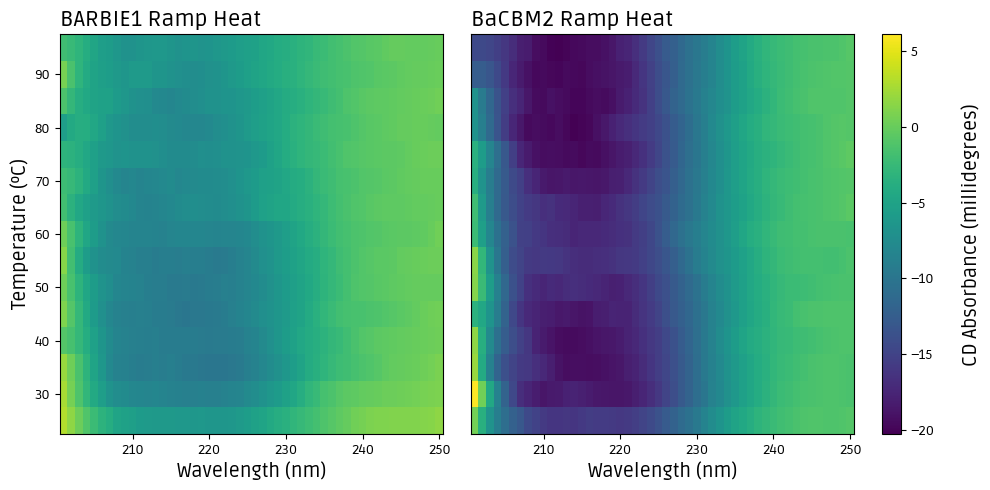

In [22]:
combined_data = np.concatenate((cd_abs_b1.flatten(), cd_abs_cbm.flatten()))

min_value = np.min(combined_data)
max_value = np.max(combined_data)

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
cax = plt.subplot(gs[2])

xb1, yb1, zb1 = proc(wls_b1, temp_b1, cd_abs_b1, min_value, max_value)
xcbm, ycbm, zcbm = proc(wls_cbm, temp_cbm, cd_abs_cbm, min_value, max_value)

vmin = min(zcbm.min(), zb1.min())
vmax = max(zcbm.max(), zb1.max())

sc1 = ax1.pcolormesh(xb1, yb1, zb1, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
ax1.set_title('BARBIE1 Ramp Heat',fontsize=16,loc='left')
ax1.set_xlabel('Wavelength (nm)', fontsize=14)
ax1.set_ylabel('Temperature (ºC)', fontsize=14)

sc2 = ax2.pcolormesh(xcbm, ycbm, zcbm, cmap='viridis', shading='auto', vmin=vmin, vmax=vmax)
ax2.set_title('BaCBM2 Ramp Heat',fontsize=16,loc='left')
ax2.set_xlabel('Wavelength (nm)', fontsize=14)
ax2.set_yticks([])

cb = fig.colorbar(sc1, cax=cax, orientation='vertical')
cb.set_label('\nCD Absorbance (millidegrees)', fontsize=14)

plt.tight_layout()
plt.savefig('results/b1xcbm_ramp.png',dpi=700)

plt.show()